# RNN based on time series: Predict Action and next steps

We aim to predict the next steps and actions based on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category

importing Jupyter notebook from Process_Training_Data_2.ipynb
      id_camino         D0         D1        D2   D3   D4   D5       A0   A1
0             0  85.591116  -9.250073 -4.257165  0.0  0.0  0.0 -0.05236  0.0
15            1  98.043500 -37.779358 -4.257165  0.0  0.0  0.0 -0.03491  0.0
25            2  91.272922 -36.852284 -4.257165  0.0  0.0  0.0 -0.00000  0.0
34            3  94.839433  -8.007799 -4.257165  0.0  0.0  0.0 -0.05236  0.0
52            4  69.791783 -31.305606 -4.257165  0.0  0.0  0.0 -0.00000  0.0
...         ...        ...        ...       ...  ...  ...  ...      ...  ...
2042        235  41.074009 -34.144254 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2048        236  40.754941 -11.474966 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2054        237  36.542365 -20.220654 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2059        238  77.290122 -11.950868 -4.257165  0.0  0.0  0.0 -0.03491  0.0
2072        239  38.729629 -32.034013 -4.257165  0.0  0.0  0.0 -0.00000  0.0

[240 rows x 9

### Get the data
First Import it using pandas

In [5]:
dataset_short = Process_Training_Data_2.get_data("./data/OSPA_training_data 2 Action.csv")

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data_2.normalize_data(dataset_short,action_vector)

N_STEPS = 8
position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,N_STEPS,position)

# Action generated trajectory model

## Multi-step model using single step-multioutput model

In [6]:
model = tf.keras.models.load_model('./data/S2S_S2A_model.h5')

In [7]:
data_stats = pd.read_csv("./data/data_stats.csv")

In [8]:
import os, sys
sys.path.append('c:\\Users\\pasky\\Documents\\Master_en_Matematicas\\PFM\\Neuronal_Networks\\path_planning')

In [9]:
from simulate_clean import get_next_state
from clean_model import tc
from classes import FlightState

In [10]:
def distance_error(x, z):
    distancia = math.sqrt(x**2 + z**2)
    return distancia

In [26]:
def generate_trajectory(model, start, target, initial_action):
  # Evaluation step (generating trajectory using the learned model)
  # start(9), target(9)

  # Number of points to generate
  num_generate = 20

  # time step used in the action
  time_step = 12/tc
  
  # Get Flight status target
  FS_target = FlightState.order_as_input(target[0:6],0,0)
  
  # Get Flight status start
  FS_start = FlightState.order_as_input(start[0:6],initial_action[0], initial_action[1])
  FS_current_state = FS_start

  # Compute the initial distance
  distance_long = target - start

  # normalize and add the action to get the Neuronal Network input
  distance = norm(distance_long, data_stats)
  input_eval = tf.expand_dims([distance], 0)
  

  # Empty vector to store the actions
  trajectory_generated = []

  # Empty vector to store the actions
  actions = []

  # First point is the initial distance
  trajectory_generated.append(distance)

  # initialize cost
  cost = 0

  #initialize distance error
  distancia_error = distance_error(*distance_long[0:2])

  #initialize action vector
  actions.append(initial_action)

  # Here batch size == 1 and sequence size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      action = tf.squeeze(predictions, 0)
      
      actions.append(np.array(action))

      #Expand the action vector with the time step
      action_long = np.append(action, time_step)

      # new_state, boolean = get_next_state(current_state(9), action(2), target_state(6))
      FS_new_state, boolean = get_next_state(FS_current_state, action_long,  FS_target)

      if boolean > 0:

        # We pass the predicted point as the next input to the model
        # along with the previous hidden state
        FS_current_state = FS_new_state
        current_state= FS_current_state.get_info_formatted()
        distance_long = target - current_state[0:6]

        distance = norm(distance_long, data_stats)
        input_eval = tf.expand_dims([distance], 0)

        trajectory_generated.append(distance)

        cost = current_state[8]

        #Error distancia = raiz(x, z, pitch, velocidad) de la suma de los cuadrados de las que estan dentro. La velocidad es... velocidad = raiz(u**2 + v**2)
        distancia_error = distance_error(*distance_long[0:2])

      elif boolean == 0:
        print("End")
        end_message = "End"
        break

      else:
        print("Error")
        end_message = "Error"
        break 

  trajectory_generated_denorm = np.apply_along_axis(denorm,1,
        trajectory_generated,data_stats)    

  return trajectory_generated_denorm, cost, distancia_error, actions, end_message

In [12]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [43]:
sample_id = 90
initial_action = np.array(samples['initial_state'][sample_id][6:8])
start = np.array(samples['initial_state'][sample_id][0:6])
target = np.array(samples['final_state'][sample_id][0:6])
teorico = []
for sample in  samples['h_path'][sample_id]:
    teorico.append(sample[0:6])
teorico = np.array(teorico)

In [44]:
trajectory, cost, distancia_error, actions, end_message= generate_trajectory(model, start, target, initial_action)
trajectory = np.array(trajectory)



Model Error
Error


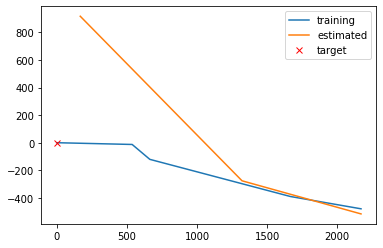

120.00238536975955
932.9995531198565


In [45]:
plt.plot(teorico[:,0], teorico[:,1],  label="training")
plt.plot(trajectory[:,0], trajectory[:,1], label="estimated")
D0 = norm([0,0,0,0,0,0], data_stats)
plt.plot(D0[0], D0[1],"rx", label="target")
plt.legend()
plt.show()
print(cost)
print(distancia_error)

In [27]:
results= samples.copy()
for sample_id, row in results.iterrows():
    print(sample_id)
    initial_action = np.array(samples['initial_state'][sample_id][6:8])
    start = np.array(samples['initial_state'][sample_id][0:6])
    target = np.array(samples['final_state'][sample_id][0:6])   
    start_time = time.time()
    trajectory, cost, distancia_error, actions, end_message = generate_trajectory(model, start, target, initial_action)
    results.at[sample_id, "h_time"] = time.time() - start_time
    results.at[sample_id, "h_actions"] = np.array(actions)
    results.at[sample_id, "h_path"] = np.array(trajectory)
    results.at[sample_id, "h_cost"] = cost
    results.at[sample_id, 'h_distance'] = distancia_error
    results.at[sample_id, 'end_message'] = end_message
    

    

0
End
1
End
2
End
3
odeint esta hervi'o
Error
4
odeint esta hervi'o
Error
5
End
6
odeint esta hervi'o
Error
7
End
8
End
9
End
10
End
11
End
12
End
13
End
14
End
15
odeint esta hervi'o
Error
16
End
17
odeint esta hervi'o
Error
18
odeint esta hervi'o
Error
19
odeint esta hervi'o
Error
20
End
21
odeint esta hervi'o
Error
22
End
23
End
24
End
25
End
26
End
27
odeint esta hervi'o
Error
28
odeint esta hervi'o
Error
29
End
30
End
31
End
32
End
33
End
34
End
35
odeint esta hervi'o
Error
36
odeint esta hervi'o
Error
37
End
38
End
39
End
40
End
41
odeint esta hervi'o
Error
42
End
43
Model Error
Error
44
End
45
End
46
odeint esta hervi'o
Error
47
End
48
odeint esta hervi'o
Error
49
End
50
odeint esta hervi'o
Error
51
End
52
End
53
odeint esta hervi'o
Error
54
End
55
End
56
End
57
End
58
odeint esta hervi'o
Error
59
End
60
odeint esta hervi'o
Error
61
End
62
odeint esta hervi'o
Error
63
End
64
odeint esta hervi'o
Error
65
End
66
End
67
End
68
odeint esta hervi'o
Error
69
odeint esta hervi'o
Error


In [28]:
comparsion_table = pd.DataFrame(columns = ["sample", "result_end", "result_error"])
comparsion_table.at["h_cost", "sample"] = samples["h_cost"].mean()
comparsion_table.at["h_cost", "result_end"] = results["h_cost"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_cost", "result_error"] = results["h_cost"].loc[results['end_message'] == "Error"].mean()

comparsion_table.at['h_distance', "sample"] = samples['h_distance'].mean()
comparsion_table.at['h_distance', "result_end"] = results['h_distance'].loc[results['end_message'] == "End"].mean()
comparsion_table.at['h_distance', "result_error"] = results['h_distance'].loc[results['end_message'] == "Error"].mean()
comparsion_table

comparsion_table.at['h_time', "sample"] = samples["h_time"].mean()
comparsion_table.at["h_time", "result_end"] = results["h_time"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_time", "result_error"] = results["h_time"].loc[results['end_message'] == "Error"].mean()
comparsion_table



,sample,result_end,result_error
h_cost,5215.39,134.246,-701.379
h_distance,3.95573,480.366,914.16
h_time,388.612,0.849489,1.35195


In [19]:
results.to_csv(r"./data/RNN_samples_metric.csv")